# DAX Standard Pivot Point Predictive Power
## Opening Position (09:00) + 10:00 Confirmation → Daily Target Hit Probabilities

**Objective:** Quantify the probabilistic advantage of the DAX opening price (09:00) and 10:00 price relative to the daily Pivot Point (PP) in predicting:
1. Daily closing outcome (green/red day, above/below PP)
2. Touch probability of R/S levels (R1-R3, S1-S3)

**Hypothesis:**
- H0: Opening position relative to PP has no predictive value (50/50 for all outcomes)
- H1: Opening above/below PP significantly affects hit probability (p < 0.05)

**Data:** M5 OHLCV bars, RTH only (09:00-17:30 Berlin time)

**Pivot Point Formulas (Standard Floor Pivots):**
```
PP = (Prev_High + Prev_Low + Prev_Close) / 3
R1 = (2 × PP) - Prev_Low
S1 = (2 × PP) - Prev_High
R2 = PP + (Prev_High - Prev_Low)
S2 = PP - (Prev_High - Prev_Low)
R3 = Prev_High + 2 × (PP - Prev_Low)
S3 = Prev_Low - 2 × (Prev_High - PP)
```

---


## Part 1: Setup and Data Loading


In [3]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Data Preparation and Session Filtering


In [4]:
print('\n[STEP 1] Fetch M5 Data and Filter RTH Sessions')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = datetime(2021, 1, 1)  # From Jan 2021

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['time'] = df.index.time
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# CRITICAL: Filter to RTH only (09:00-17:30)
# Why: Pivot Points use the official session close (17:30), not after-hours data
df_rth = df[
    (df['hour'] >= 9) & 
    ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))
].copy()

print(f'[OK] Filtered to RTH (09:00-17:30): {len(df_rth)} candles')
print(f'Date range: {df_rth.index.min().date()} to {df_rth.index.max().date()}')


[STEP 1] Fetch M5 Data and Filter RTH Sessions


2025-12-09 21:57:25,746 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2020-09-14 22:00:00+00:00 to 2025-11-27 22:55:00+00:00
2025-12-09 21:57:25,747 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2021-01-01 00:00:00, end=2025-11-27 22:55:00+00:00


Fetching M5 data: 2021-01-01 to 2025-11-27


2025-12-09 21:57:31,131 - shared.database_connector - INFO - [OK] Fetched 336793 candles (2021-01-03 22:00:00+00:00 to 2025-11-27 22:55:00+00:00)


[OK] Fetched 336793 M5 candles
[OK] Filtered to RTH (09:00-17:30): 130353 candles
Date range: 2021-01-04 to 2025-11-27


## Step 2: Calculate Previous Day OHLC (No Look-Ahead)


In [5]:
print('\n[STEP 2] Compute Previous Day OHLC for Pivot Calculation')
print('='*80)

# Aggregate to daily (using RTH-filtered data only)
daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 50:  # Need at least ~4 hours of data
        continue
    
    # Daily OHLC
    daily_open = day_data.iloc[0]['open']  # 09:00 open
    daily_high = day_data['high'].max()
    daily_low = day_data['low'].min()
    daily_close = day_data.iloc[-1]['close']  # 17:30 close
    
    # Extract 10:00 price
    bar_10am = day_data[(day_data['hour'] == 10) & (day_data['minute'] == 0)]
    if len(bar_10am) > 0:
        price_10am = bar_10am.iloc[0]['close']
    else:
        price_10am = np.nan
    
    row = {
        'date': date,
        'open_9am': daily_open,
        'high': daily_high,
        'low': daily_low,
        'close_530pm': daily_close,
        'price_10am': price_10am,
        'n_bars': len(day_data),
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')

# CRITICAL: Shift to get PREVIOUS day's OHLC (no look-ahead bias)
# Why: Pivots for "Today" are calculated using "Yesterday's" data
df_daily['prev_high'] = df_daily['high'].shift(1)
df_daily['prev_low'] = df_daily['low'].shift(1)
df_daily['prev_close'] = df_daily['close_530pm'].shift(1)

# Drop first day (no previous data)
df_daily = df_daily[df_daily['prev_close'].notna()].reset_index(drop=True)

print(f'[OK] Valid days with previous OHLC: {len(df_daily)}')
print(f'Sample:')
print(df_daily[['date', 'open_9am', 'high', 'low', 'close_530pm', 'prev_high', 'prev_low', 'prev_close']].head(10))


[STEP 2] Compute Previous Day OHLC for Pivot Calculation
[OK] Aggregated to 1266 trading days
[OK] Valid days with previous OHLC: 1265
Sample:
         date   open_9am       high        low  close_530pm  prev_high  \
0  2021-01-05  13703.203  13729.249  13564.799    13666.189  13906.399   
1  2021-01-06  13654.257  13920.299  13638.749    13908.159  13729.249   
2  2021-01-07  13950.399  14007.399  13913.259    13959.149  13920.299   
3  2021-01-08  14097.297  14099.289  14004.759    14063.799  14007.399   
4  2021-01-11  13946.299  14001.297  13804.267    13950.179  14099.289   
5  2021-01-12  13963.279  14002.299  13840.179    13871.189  14001.297   
6  2021-01-13  13917.749  13977.799  13865.749    13935.199  14002.299   
7  2021-01-14  14001.297  14032.779  13940.289    13987.669  13977.799   
8  2021-01-15  13926.399  13950.399  13671.259    13769.689  14032.779   
9  2021-01-18  13772.779  13856.697  13761.789    13848.689  13950.399   

    prev_low  prev_close  
0  13591.169  

## Step 3: Pivot Point Calculation


In [6]:
print('\n[STEP 3] Calculate Standard Floor Pivot Points')
print('='*80)

# Standard Pivot Point formulas
df_daily['PP'] = (df_daily['prev_high'] + df_daily['prev_low'] + df_daily['prev_close']) / 3

df_daily['R1'] = (2 * df_daily['PP']) - df_daily['prev_low']
df_daily['S1'] = (2 * df_daily['PP']) - df_daily['prev_high']

df_daily['R2'] = df_daily['PP'] + (df_daily['prev_high'] - df_daily['prev_low'])
df_daily['S2'] = df_daily['PP'] - (df_daily['prev_high'] - df_daily['prev_low'])

df_daily['R3'] = df_daily['prev_high'] + 2 * (df_daily['PP'] - df_daily['prev_low'])
df_daily['S3'] = df_daily['prev_low'] - 2 * (df_daily['prev_high'] - df_daily['PP'])

print(f'[OK] Pivot points calculated')
print(f'\nSample Pivot Levels:')
print(df_daily[['date', 'PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']].head(10))


[STEP 3] Calculate Standard Floor Pivot Points
[OK] Pivot points calculated

Sample Pivot Levels:
         date            PP            R1            R2            R3  \
0  2021-01-05  13715.242333  13839.315667  14030.472333  14154.545667   
1  2021-01-06  13653.412333  13742.025667  13817.862333  13906.475667   
2  2021-01-07  13822.402333  14006.055667  14103.952333  14287.605667   
3  2021-01-08  13959.935667  14006.612333  14054.075667  14100.752333   
4  2021-01-11  14055.949000  14107.139000  14150.479000  14201.669000   
5  2021-01-12  13918.581000  14032.895000  14115.611000  14229.925000   
6  2021-01-13  13904.555667  13968.932333  14066.675667  14131.052333   
7  2021-01-14  13926.249000  13986.749000  14038.299000  14098.799000   
8  2021-01-15  13986.912333  14033.535667  14079.402333  14126.025667   
9  2021-01-18  13797.115667  13922.972333  14076.255667  14202.112333   

             S1            S2            S3  
0  13524.085667  13400.012333  13208.855667  
1  13

## Step 4: Define Conditions and Outcomes


In [7]:
print('\n[STEP 4] Define Conditions (Open/10AM vs PP) and Outcomes (Hits, Closes)')
print('='*80)

# Conditions (Opening Position Relative to PP)
df_daily['open_above_pp'] = df_daily['open_9am'] > df_daily['PP']
df_daily['open_below_pp'] = df_daily['open_9am'] < df_daily['PP']

# 10:00 AM Confirmation
df_daily['10am_above_pp'] = df_daily['price_10am'] > df_daily['PP']
df_daily['10am_below_pp'] = df_daily['price_10am'] < df_daily['PP']

# Outcomes: Did we hit R/S levels?
df_daily['hit_r1'] = df_daily['high'] >= df_daily['R1']
df_daily['hit_r2'] = df_daily['high'] >= df_daily['R2']
df_daily['hit_r3'] = df_daily['high'] >= df_daily['R3']

df_daily['hit_s1'] = df_daily['low'] <= df_daily['S1']
df_daily['hit_s2'] = df_daily['low'] <= df_daily['S2']
df_daily['hit_s3'] = df_daily['low'] <= df_daily['S3']

# Closing Outcomes
df_daily['closed_higher'] = df_daily['close_530pm'] > df_daily['open_9am']  # Green day
df_daily['closed_above_pp'] = df_daily['close_530pm'] > df_daily['PP']

print(f'[OK] Conditions and outcomes defined')

# Distribution of opening conditions
n_above = df_daily['open_above_pp'].sum()
n_below = df_daily['open_below_pp'].sum()
n_at = len(df_daily) - n_above - n_below

print(f'\nOpening Position Distribution:')
print(f'  Open > PP:  {n_above:4d} days ({n_above/len(df_daily)*100:5.1f}%)')
print(f'  Open < PP:  {n_below:4d} days ({n_below/len(df_daily)*100:5.1f}%)')
print(f'  Open ≈ PP:  {n_at:4d} days ({n_at/len(df_daily)*100:5.1f}%)')


[STEP 4] Define Conditions (Open/10AM vs PP) and Outcomes (Hits, Closes)
[OK] Conditions and outcomes defined

Opening Position Distribution:
  Open > PP:   709 days ( 56.0%)
  Open < PP:   556 days ( 44.0%)
  Open ≈ PP:     0 days (  0.0%)


## Step 5: Statistical Analysis - Scenario 1 (09:00 Open > PP)


In [8]:
print('\n[STEP 5] SCENARIO 1: OPEN (09:00) > PP')
print('='*80)

# Filter to days where open > PP
df_above = df_daily[df_daily['open_above_pp']].copy()
n_above = len(df_above)

if n_above > 0:
    # Probabilities
    p_close_green = df_above['closed_higher'].sum() / n_above
    p_close_above_pp = df_above['closed_above_pp'].sum() / n_above
    
    p_hit_r1 = df_above['hit_r1'].sum() / n_above
    p_hit_r2 = df_above['hit_r2'].sum() / n_above
    p_hit_r3 = df_above['hit_r3'].sum() / n_above
    
    p_hit_s1 = df_above['hit_s1'].sum() / n_above  # Risk (reversal)
    
    # Binomial tests (vs 50% baseline)
    binom_green = stats.binomtest(df_above['closed_higher'].sum(), n_above, 0.5, alternative='two-sided')
    binom_r1 = stats.binomtest(df_above['hit_r1'].sum(), n_above, 0.5, alternative='two-sided')
    
    print(f'\nOccurrence: {n_above} days ({n_above/len(df_daily)*100:.1f}% of all days)')
    print(f'\n[CLOSING OUTCOMES]')
    print(f'  Probability of Closing Green (Close > Open):  {p_close_green:.1%}  (p={binom_green.pvalue:.4f})')
    print(f'  Probability of Closing Above PP:              {p_close_above_pp:.1%}')
    
    print(f'\n[RESISTANCE TARGETS]')
    print(f'  Probability of Hitting R1:  {p_hit_r1:.1%}  (p={binom_r1.pvalue:.4f})')
    print(f'  Probability of Hitting R2:  {p_hit_r2:.1%}')
    print(f'  Probability of Hitting R3:  {p_hit_r3:.1%}')
    
    print(f'\n[RISK (Reversal)]')
    print(f'  Probability of Dropping to S1:  {p_hit_s1:.1%}')
    
    # Statistical significance
    sig_green = '[SIG]' if binom_green.pvalue < 0.05 else '[NOT SIG]'
    sig_r1 = '[SIG]' if binom_r1.pvalue < 0.05 else '[NOT SIG]'
    
    print(f'\n[SIGNIFICANCE]')
    print(f'  Closing Green vs 50%:  {sig_green}')
    print(f'  Hitting R1 vs 50%:     {sig_r1}')
else:
    print('[NO DATA] No days with Open > PP')


[STEP 5] SCENARIO 1: OPEN (09:00) > PP

Occurrence: 709 days (56.0% of all days)

[CLOSING OUTCOMES]
  Probability of Closing Green (Close > Open):  56.7%  (p=0.0004)
  Probability of Closing Above PP:              80.1%

[RESISTANCE TARGETS]
  Probability of Hitting R1:  79.1%  (p=0.0000)
  Probability of Hitting R2:  47.7%
  Probability of Hitting R3:  21.6%

[RISK (Reversal)]
  Probability of Dropping to S1:  18.3%

[SIGNIFICANCE]
  Closing Green vs 50%:  [SIG]
  Hitting R1 vs 50%:     [SIG]


## Step 6: Statistical Analysis - Scenario 2 (09:00 Open < PP)


In [9]:
print('\n[STEP 6] SCENARIO 2: OPEN (09:00) < PP')
print('='*80)

# Filter to days where open < PP
df_below = df_daily[df_daily['open_below_pp']].copy()
n_below = len(df_below)

if n_below > 0:
    # Probabilities
    p_close_red = (1 - df_below['closed_higher'].sum() / n_below)  # Red day
    p_close_below_pp = (1 - df_below['closed_above_pp'].sum() / n_below)
    
    p_hit_s1 = df_below['hit_s1'].sum() / n_below
    p_hit_s2 = df_below['hit_s2'].sum() / n_below
    p_hit_s3 = df_below['hit_s3'].sum() / n_below
    
    p_hit_r1 = df_below['hit_r1'].sum() / n_below  # Risk (rally)
    
    # Binomial tests
    binom_red = stats.binomtest((n_below - df_below['closed_higher'].sum()), n_below, 0.5, alternative='two-sided')
    binom_s1 = stats.binomtest(df_below['hit_s1'].sum(), n_below, 0.5, alternative='two-sided')
    
    print(f'\nOccurrence: {n_below} days ({n_below/len(df_daily)*100:.1f}% of all days)')
    print(f'\n[CLOSING OUTCOMES]')
    print(f'  Probability of Closing Red (Close < Open):  {p_close_red:.1%}  (p={binom_red.pvalue:.4f})')
    print(f'  Probability of Closing Below PP:            {p_close_below_pp:.1%}')
    
    print(f'\n[SUPPORT TARGETS]')
    print(f'  Probability of Hitting S1:  {p_hit_s1:.1%}  (p={binom_s1.pvalue:.4f})')
    print(f'  Probability of Hitting S2:  {p_hit_s2:.1%}')
    print(f'  Probability of Hitting S3:  {p_hit_s3:.1%}')
    
    print(f'\n[RISK (Rally)]')
    print(f'  Probability of Rallying to R1:  {p_hit_r1:.1%}')
    
    # Statistical significance
    sig_red = '[SIG]' if binom_red.pvalue < 0.05 else '[NOT SIG]'
    sig_s1 = '[SIG]' if binom_s1.pvalue < 0.05 else '[NOT SIG]'
    
    print(f'\n[SIGNIFICANCE]')
    print(f'  Closing Red vs 50%:   {sig_red}')
    print(f'  Hitting S1 vs 50%:    {sig_s1}')
else:
    print('[NO DATA] No days with Open < PP')


[STEP 6] SCENARIO 2: OPEN (09:00) < PP

Occurrence: 556 days (44.0% of all days)

[CLOSING OUTCOMES]
  Probability of Closing Red (Close < Open):  48.0%  (p=0.3732)
  Probability of Closing Below PP:            76.1%

[SUPPORT TARGETS]
  Probability of Hitting S1:  78.8%  (p=0.0000)
  Probability of Hitting S2:  50.2%
  Probability of Hitting S3:  29.0%

[RISK (Rally)]
  Probability of Rallying to R1:  15.1%

[SIGNIFICANCE]
  Closing Red vs 50%:   [NOT SIG]
  Hitting S1 vs 50%:    [SIG]


## Step 7: Statistical Analysis - Scenario 3 (10:00 AM Confirmation)


In [10]:
print('\n[STEP 7] SCENARIO 3: 10:00 AM CONFIRMATION (Price > PP at 10:00)')
print('='*80)

# Filter to days with valid 10:00 data and 10am > PP
df_10am_above = df_daily[
    (df_daily['price_10am'].notna()) & 
    (df_daily['10am_above_pp'])
].copy()

n_10am_above = len(df_10am_above)

if n_10am_above > 0:
    p_hit_r1_10am = df_10am_above['hit_r1'].sum() / n_10am_above
    p_hit_r2_10am = df_10am_above['hit_r2'].sum() / n_10am_above
    p_hit_r3_10am = df_10am_above['hit_r3'].sum() / n_10am_above
    
    # Calculate delta vs 09:00 open (if we have both)
    df_both_above = df_daily[
        (df_daily['open_above_pp']) & 
        (df_daily['price_10am'].notna()) & 
        (df_daily['10am_above_pp'])
    ]
    
    if len(df_both_above) > 0:
        p_hit_r1_open_only = df_above['hit_r1'].sum() / len(df_above)
        delta_r1 = p_hit_r1_10am - p_hit_r1_open_only
    else:
        delta_r1 = 0
    
    print(f'\nOccurrence: {n_10am_above} days (10:00 > PP)')
    print(f'\n[RESISTANCE TARGETS after 10:00 Confirmation]')
    print(f'  Probability of Hitting R1:  {p_hit_r1_10am:.1%}  (Delta vs 09:00 Open: {delta_r1:+.1%})')
    print(f'  Probability of Hitting R2:  {p_hit_r2_10am:.1%}')
    print(f'  Probability of Hitting R3:  {p_hit_r3_10am:.1%}')
    
    if abs(delta_r1) > 0.05:
        print(f'\n[CONFIRMATION EFFECT] 10:00 confirmation changes R1 probability by {abs(delta_r1):.1%}')
    else:
        print(f'\n[CONFIRMATION EFFECT] 10:00 confirmation adds minimal value (< 5% delta)')
else:
    print('[NO DATA] No days with valid 10:00 data above PP')

# Same for 10:00 below PP
df_10am_below = df_daily[
    (df_daily['price_10am'].notna()) & 
    (df_daily['10am_below_pp'])
].copy()

if len(df_10am_below) > 0:
    p_hit_s1_10am = df_10am_below['hit_s1'].sum() / len(df_10am_below)
    print(f'\n[SUPPORT TARGETS after 10:00 Confirmation (Price < PP)]')
    print(f'  Probability of Hitting S1:  {p_hit_s1_10am:.1%}')


[STEP 7] SCENARIO 3: 10:00 AM CONFIRMATION (Price > PP at 10:00)

Occurrence: 703 days (10:00 > PP)

[RESISTANCE TARGETS after 10:00 Confirmation]
  Probability of Hitting R1:  81.8%  (Delta vs 09:00 Open: +2.7%)
  Probability of Hitting R2:  49.8%
  Probability of Hitting R3:  22.5%

[CONFIRMATION EFFECT] 10:00 confirmation adds minimal value (< 5% delta)

[SUPPORT TARGETS after 10:00 Confirmation (Price < PP)]
  Probability of Hitting S1:  82.7%


## Step 8: Visualization



[STEP 8] Visualizations


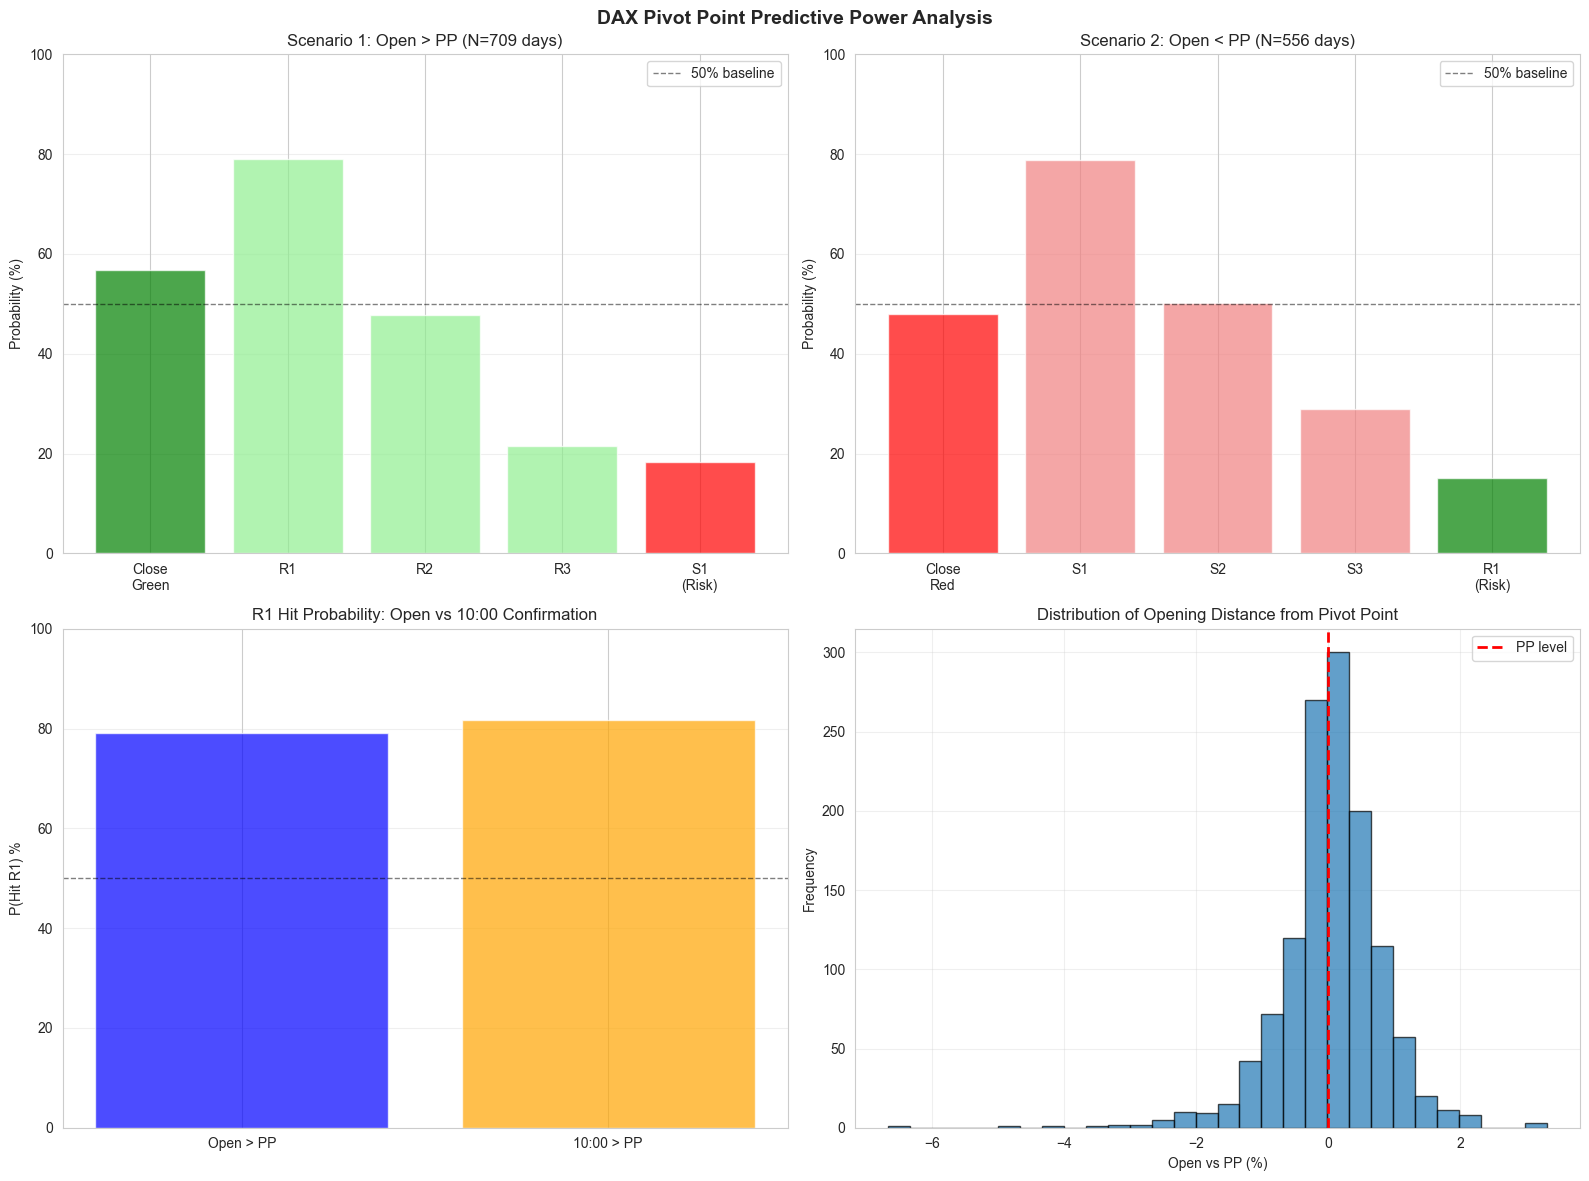

[OK] Visualizations created


In [11]:
print('\n[STEP 8] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DAX Pivot Point Predictive Power Analysis', fontsize=14, fontweight='bold')

# Plot 1: Hit probabilities (Open > PP)
ax = axes[0, 0]
if n_above > 0:
    targets = ['Close\nGreen', 'R1', 'R2', 'R3', 'S1\n(Risk)']
    probs = [
        df_above['closed_higher'].sum() / n_above,
        df_above['hit_r1'].sum() / n_above,
        df_above['hit_r2'].sum() / n_above,
        df_above['hit_r3'].sum() / n_above,
        df_above['hit_s1'].sum() / n_above,
    ]
    colors = ['green', 'lightgreen', 'lightgreen', 'lightgreen', 'red']
    ax.bar(targets, [p * 100 for p in probs], color=colors, alpha=0.7)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
    ax.set_ylabel('Probability (%)')
    ax.set_title(f'Scenario 1: Open > PP (N={n_above} days)')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Hit probabilities (Open < PP)
ax = axes[0, 1]
if n_below > 0:
    targets = ['Close\nRed', 'S1', 'S2', 'S3', 'R1\n(Risk)']
    probs = [
        1 - (df_below['closed_higher'].sum() / n_below),
        df_below['hit_s1'].sum() / n_below,
        df_below['hit_s2'].sum() / n_below,
        df_below['hit_s3'].sum() / n_below,
        df_below['hit_r1'].sum() / n_below,
    ]
    colors = ['red', 'lightcoral', 'lightcoral', 'lightcoral', 'green']
    ax.bar(targets, [p * 100 for p in probs], color=colors, alpha=0.7)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
    ax.set_ylabel('Probability (%)')
    ax.set_title(f'Scenario 2: Open < PP (N={n_below} days)')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Comparison of R1 hit probability
ax = axes[1, 0]
scenarios = ['Open > PP', '10:00 > PP']
if n_above > 0 and n_10am_above > 0:
    probs_r1 = [
        df_above['hit_r1'].sum() / n_above * 100,
        df_10am_above['hit_r1'].sum() / n_10am_above * 100,
    ]
    ax.bar(scenarios, probs_r1, color=['blue', 'orange'], alpha=0.7)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('P(Hit R1) %')
    ax.set_title('R1 Hit Probability: Open vs 10:00 Confirmation')
    ax.set_ylim([0, 100])
    ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Distribution of opening distance from PP
ax = axes[1, 1]
df_daily['open_vs_pp_pct'] = (df_daily['open_9am'] - df_daily['PP']) / df_daily['PP'] * 100
ax.hist(df_daily['open_vs_pp_pct'], bins=30, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='PP level')
ax.set_xlabel('Open vs PP (%)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Opening Distance from Pivot Point')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 9: Summary Report


In [12]:
print('\n[STEP 9] FINAL SUMMARY REPORT')
print('='*80)

print(f'''
--- PIVOT POINT ANALYSIS RESULTS ---

Data Range: {df_daily['date'].min()} to {df_daily['date'].max()}
Total Days Analyzed: {len(df_daily)}

================================================================================
SCENARIO 1: OPEN (09:00) > PP
================================================================================
''')

if n_above > 0:
    print(f'Occurrence: {n_above/len(df_daily):.1%} of days ({n_above} days)\n')
    print(f'Probability of Closing Green:     {df_above["closed_higher"].sum() / n_above:.1%}')
    print(f'Probability of Hitting R1:        {df_above["hit_r1"].sum() / n_above:.1%}')
    print(f'Probability of Hitting R2:        {df_above["hit_r2"].sum() / n_above:.1%}')
    print(f'Probability of Hitting R3:        {df_above["hit_r3"].sum() / n_above:.1%}')
    print(f'Risk (Dropping to S1):            {df_above["hit_s1"].sum() / n_above:.1%}')

print(f'''
================================================================================
SCENARIO 2: OPEN (09:00) < PP
================================================================================
''')

if n_below > 0:
    print(f'Occurrence: {n_below/len(df_daily):.1%} of days ({n_below} days)\n')
    print(f'Probability of Closing Red:       {(1 - df_below["closed_higher"].sum() / n_below):.1%}')
    print(f'Probability of Hitting S1:        {df_below["hit_s1"].sum() / n_below:.1%}')
    print(f'Probability of Hitting S2:        {df_below["hit_s2"].sum() / n_below:.1%}')
    print(f'Probability of Hitting S3:        {df_below["hit_s3"].sum() / n_below:.1%}')
    print(f'Risk (Rallying to R1):            {df_below["hit_r1"].sum() / n_below:.1%}')

print(f'''
================================================================================
SCENARIO 3: 10:00 AM > PP (Confirmation)
================================================================================
''')

if n_10am_above > 0:
    print(f'Occurrence: {n_10am_above} days with valid 10:00 data\n')
    print(f'Probability of Hitting R1:        {df_10am_above["hit_r1"].sum() / n_10am_above:.1%}')
    if abs(delta_r1) > 0.01:
        print(f'Delta vs 09:00 Open:              {delta_r1:+.1%}')
    print(f'Probability of Hitting R2:        {df_10am_above["hit_r2"].sum() / n_10am_above:.1%}')
    print(f'Probability of Hitting R3:        {df_10am_above["hit_r3"].sum() / n_10am_above:.1%}')

print(f'''
================================================================================
KEY FINDINGS
================================================================================
''')

# Determine if edges exist
if n_above > 0:
    p_r1_above = df_above['hit_r1'].sum() / n_above
    if p_r1_above > 0.60:
        print(f'[EDGE FOUND] Open > PP → R1 hit {p_r1_above:.0%} (> 60%)')
    elif p_r1_above > 0.55:
        print(f'[WEAK EDGE] Open > PP → R1 hit {p_r1_above:.0%} (modest edge)')
    else:
        print(f'[NO EDGE] Open > PP → R1 hit {p_r1_above:.0%} (≈ 50%, random)')

if n_below > 0:
    p_s1_below = df_below['hit_s1'].sum() / n_below
    if p_s1_below > 0.60:
        print(f'[EDGE FOUND] Open < PP → S1 hit {p_s1_below:.0%} (> 60%)')
    elif p_s1_below > 0.55:
        print(f'[WEAK EDGE] Open < PP → S1 hit {p_s1_below:.0%} (modest edge)')
    else:
        print(f'[NO EDGE] Open < PP → S1 hit {p_s1_below:.0%} (≈ 50%, random)')

print(f'\n[OK] Analysis complete')
print('='*80)


[STEP 9] FINAL SUMMARY REPORT

--- PIVOT POINT ANALYSIS RESULTS ---

Data Range: 2021-01-05 to 2025-11-27
Total Days Analyzed: 1265

SCENARIO 1: OPEN (09:00) > PP

Occurrence: 56.0% of days (709 days)

Probability of Closing Green:     56.7%
Probability of Hitting R1:        79.1%
Probability of Hitting R2:        47.7%
Probability of Hitting R3:        21.6%
Risk (Dropping to S1):            18.3%

SCENARIO 2: OPEN (09:00) < PP

Occurrence: 44.0% of days (556 days)

Probability of Closing Red:       48.0%
Probability of Hitting S1:        78.8%
Probability of Hitting S2:        50.2%
Probability of Hitting S3:        29.0%
Risk (Rallying to R1):            15.1%

SCENARIO 3: 10:00 AM > PP (Confirmation)

Occurrence: 703 days with valid 10:00 data

Probability of Hitting R1:        81.8%
Delta vs 09:00 Open:              +2.7%
Probability of Hitting R2:        49.8%
Probability of Hitting R3:        22.5%

KEY FINDINGS

[EDGE FOUND] Open > PP → R1 hit 79% (> 60%)
[EDGE FOUND] Open < P